# Práctica Multiobjetivo – MW14

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume

problem = get_problem("mw14", n_var=30, n_obj=3)

N_VAR = problem.n_var
N_OBJ = problem.n_obj
XL = np.asarray(problem.xl)
XU = np.asarray(problem.xu)

BUDGET = 10_000
POP_SIZE = 300
N_GEN = max(1, (BUDGET // POP_SIZE) - 1)

FEAS_EPS = 1e-6
PENALTY = 1000.0

## Introducción

MW14 es un problema multiobjetivo perteneciente a la familia de benchmarks MW, caracterizado por presentar un frente de Pareto separable, es decir, compuesto por múltiples superficies disjuntas en el espacio de objetivos.

En esta práctica se utiliza la configuración indicada en el enunciado:

- Número de funciones: 3
- Número de variables de decisión: 30
- Dominio de las variables: [0, 1.5]
- Presupuesto máximo de evaluaciones: 10 000

El objetivo es analizar el comportamiento de distintos algoritmos multiobjetivo bajo un presupuesto limitado en un problema con múltiples superficies de Pareto disjuntas.

## Funciones auxiliares: evaluación, Pareto (ranks) y crowding distance

En esta sección se definen las funciones auxiliares necesarias para la evaluación y selección de la población en los algoritmos evolutivos multiobjetivo.

- La función `eval_pop` evalúa una población de soluciones, calculando los valores de las funciones objetivo y la violación total de las restricciones (CV).  
- La función `nd_ranks` realiza la ordenación no dominada teniendo en cuenta las restricciones, priorizando siempre a los individuos factibles frente a los no factibles.  
- La función `crowding_distance` calcula la distancia de crowding para mantener diversidad dentro de cada frente de Pareto.
- La función `_filter_nd_feasible` obtiene el frente de Pareto priorizando las soluciones factibles (CV ≤ 0). En caso de no existir soluciones factibles, se seleccionan aquellas con menor violación de restricciones.


Estas funciones permiten implementar un proceso de selección ambiental similar al de NSGA-II, adaptado al manejo de restricciones del problema MW14.

In [2]:
def eval_pop(X, eps_eq=1e-4):
    out = problem.evaluate(X, return_values_of=['F', 'G', 'H'])

    if isinstance(out, (tuple, list)):
        F = out[0]
        G = out[1] if len(out) > 1 else None
        H = out[2] if len(out) > 2 else None
    else:
        F, G, H = out, None, None

    CV = np.zeros(len(F), dtype=float)

    # Acumulación de violación de desigualdades
    if G is not None:
        G = np.asarray(G)
        if G.ndim == 1:
            G = G[:, None]
        CV += np.sum(np.maximum(G, 0.0), axis=1)

    # Acumulación de violación de igualdades (con tolerancia)
    if H is not None:
        H = np.asarray(H)
        if H.ndim == 1:
            H = H[:, None]
        CV += np.sum(np.maximum(np.abs(H) - eps_eq, 0.0), axis=1)

    return np.asarray(F), np.asarray(CV).reshape(-1)


def nd_ranks(F, CV=None):
    N = len(F)
    if CV is None:
        CV = np.zeros(N)

    CV = np.asarray(CV).reshape(-1)
    feas = (CV <= FEAS_EPS)

    # frentes y rangos
    fronts_all = []
    rank = np.full(N, fill_value=10**9, dtype=int)

    # Ordenación no dominada factibles
    if np.any(feas):
        fronts_feas = NonDominatedSorting().do(F[feas])
        feas_idx = np.where(feas)[0]
        for r, front in enumerate(fronts_feas):
            real_idx = feas_idx[front]
            fronts_all.append(real_idx)
            rank[real_idx] = r
        next_rank = len(fronts_feas)
    else:
        next_rank = 0

    # no factibles ordenación por violación
    infeas_idx = np.where(~feas)[0]
    if len(infeas_idx) > 0:
        order = infeas_idx[np.argsort(CV[infeas_idx])]
        fronts_all.append(order)
        rank[order] = next_rank

    return fronts_all, rank


def crowding_distance(F_front):
    k = len(F_front)
    if k == 0:
        return np.array([])
    if k <= 2:
        return np.full(k, np.inf)

    m = F_front.shape[1]
    cd = np.zeros(k, dtype=float)

    # Contribución de cada objetivo al crowding
    for j in range(m):
        order = np.argsort(F_front[:, j])
        cd[order[0]] = np.inf
        cd[order[-1]] = np.inf

        fmin = F_front[order[0], j]
        fmax = F_front[order[-1], j]
        if fmax == fmin:
            continue

        # Acumulación según vecinos ordenados
        for t in range(1, k - 1):
            if np.isinf(cd[order[t]]):
                continue
            prevv = F_front[order[t - 1], j]
            nextv = F_front[order[t + 1], j]
            cd[order[t]] += (nextv - prevv) / (fmax - fmin)

    return cd


def _filter_nd_feasible(F, CV=None):
    # priorizaar factibilidad
    F = np.asarray(F)
    if CV is None:
        nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
        return np.unique(F[nd], axis=0)

    # Separación factibles - no factibles con tolerancia
    CV = np.asarray(CV).reshape(-1)
    feas = (CV <= FEAS_EPS)
    if np.any(feas):
        # Filtrado ND sobre las soluciones factibles
        Ff = F[feas]
        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        return np.unique(Ff[nd], axis=0)
    else:
        # caso sin factibles selección por menor violación
        idx = np.argsort(CV)[:min(len(CV), 100)]
        return np.unique(F[idx], axis=0)

## Métricas de evaluación

La comparación cuantitativa entre algoritmos se realiza mediante las siguientes métricas:

- Hipervolumen (HV): mide simultáneamente convergencia y diversidad del frente aproximado.
- Espaciado (SPA): evalúa la uniformidad en la distribución de las soluciones.
- Dispersión (SPR): mide la extensión del frente aproximado.

Para cada ejecución se calcula un punto de referencia común a partir de los frentes no dominados obtenidos por todos los algoritmos.

In [3]:
def spacing(front):
    front = np.asarray(front)
    if len(front) < 2:
        return 0.0
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    np.fill_diagonal(d, np.inf)
    return float(np.mean(np.min(d, axis=1)))


def range_metric(front):
    front = np.asarray(front)
    mn = np.min(front, axis=0)
    mx = np.max(front, axis=0)
    return float(np.mean(mx - mn))


def ref_point_from_front(front, margin=0.1):
    front = np.asarray(front)
    return np.max(front, axis=0) + margin


def calculate_metrics(front, ref_point):
    front = np.asarray(front)
    hv = float(Hypervolume(ref_point).do(front))
    spr = range_metric(front)
    spa = spacing(front)
    return hv, spr, spa

## Visualización del frente de Pareto

Para analizar el comportamiento de los algoritmos, se representa el frente de Pareto real del problema junto con los frentes aproximados obtenidos por cada método.

Dado que MW14 presenta un frente separable con múltiples superficies disjuntas, la visualización se realiza en 3D para facilitar la interpretación de los resultados.

In [4]:
def plot_pareto_3d_mw14(problem, F_nsga, F_spea, F_ga,
                       title="MW14 - Pareto real vs algoritmos"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    real_pf = None
    try:
        real_pf = problem.pareto_front()
    except Exception:
        real_pf = None

    if real_pf is None or len(real_pf) == 0:
        try:
            real_pf = problem.pareto_front(n_pareto_points=2000)
        except Exception:
            real_pf = None

    # Frente de Pareto real
    if real_pf is not None and len(real_pf) > 0:
        ax.scatter(real_pf[:, 0], real_pf[:, 1], real_pf[:, 2],
                   color="red", alpha=0.15,
                   edgecolor="none", s=15,
                   label="Frente Pareto real")

    # SPEA2
    ax.scatter(F_spea[:, 0], F_spea[:, 1], F_spea[:, 2],
               color="orange", marker="^",
               s=50, alpha=0.55,
               edgecolors="black", linewidths=0.3,
               label="SPEA2")

    # NSGA-II
    ax.scatter(F_nsga[:, 0], F_nsga[:, 1], F_nsga[:, 2],
               color="green", marker="x",
               s=70, alpha=0.8,
               linewidths=1.0,
               label="NSGA-II")

    # GA
    ax.scatter(F_ga[:, 0], F_ga[:, 1], F_ga[:, 2],
               color="blue", marker="o",
               s=12, alpha=0.15,
               label="GA v1")

    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_zlabel("f3")
    ax.set_title(title)
    ax.legend()
    plt.show()

In [5]:
def plot_pareto_3d_mw14_4(problem, F_nsga, F_spea, F_ga1, F_ga2,
                          title="MW14 - Pareto real vs algoritmos",
                          max_ga_points=800):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Frente real
    real_pf = None
    try:
        real_pf = problem.pareto_front()
    except Exception:
        real_pf = None
    if real_pf is None or len(real_pf) == 0:
        try:
            real_pf = problem.pareto_front(n_pareto_points=2500)
        except Exception:
            real_pf = None

    if real_pf is not None and len(real_pf) > 0:
        ax.scatter(real_pf[:, 0], real_pf[:, 1], real_pf[:, 2],
                   color="red", alpha=0.10, s=6, label="Frente Pareto real")

    def subsample(F, k):
        F = np.asarray(F)
        if len(F) <= k:
            return F
        idx = np.random.choice(len(F), k, replace=False)
        return F[idx]

    F_ga1p = subsample(F_ga1, max_ga_points)
    F_ga2p = subsample(F_ga2, max_ga_points)

    ax.scatter(F_ga1p[:, 0], F_ga1p[:, 1], F_ga1p[:, 2],
               color="blue", marker="o", s=10, alpha=0.20, label="GA v1")

    ax.scatter(F_ga2p[:, 0], F_ga2p[:, 1], F_ga2p[:, 2],
               color="purple", marker="s", s=10, alpha=0.20, label="GA v2")

    ax.scatter(F_spea[:, 0], F_spea[:, 1], F_spea[:, 2],
               color="orange", marker="^", s=60, alpha=0.95,
               edgecolors="black", linewidths=0.4, label="SPEA2")

    ax.scatter(F_nsga[:, 0], F_nsga[:, 1], F_nsga[:, 2],
               color="green", marker="x", s=80, alpha=1.0,
               linewidths=1.2, label="NSGA-II")

    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_zlabel("f3")
    ax.set_title(title)
    ax.legend()
    plt.show()

## Algoritmos evaluados

Se comparan los siguientes algoritmos multiobjetivo:

- NSGA-II: algoritmo clásico basado en ordenación no dominada y crowding distance, implementado en pymoo.
- SPEA2: algoritmo basado en fuerza y archivo externo, también implementado en pymoo.
- GA v1: algoritmo genético adaptado con cruce aritmético y mutación gaussiana.
- GA v2: variante del GA adaptado que emplea cruce SBX (Simulated Binary Crossover) y mutación polinómica.

Ambas versiones del GA incorporan manejo explícito de restricciones mediante penalización y selección ambiental basada en dominancia.

Los algoritmos NSGA-II y SPEA2 se utilizan como métodos de referencia y se ejecutan empleando la configuración estándar para problemas continuos.

En ambos casos se utilizan:
- Cruce SBX (Simulated Binary Crossover) con probabilidad 0.9 y parámetro η = 15.
- Mutación polinómica (PM) con probabilidad 1 / N_VAR y parámetro η = 20.

Esta configuración es muy común en la literatura y es la que pymoo utiliza por defecto para problemas con variables reales. La probabilidad de mutación se define de forma inversamente proporcional al número de variables, de modo que, en promedio, se muta una variable por individuo en cada generación.

Además, se habilita la eliminación de duplicados para favorecer la diversidad de la población.

In [6]:
def run_nsga2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')

    CV = res.pop.get("CV")
    if CV is not None:
        CV = np.asarray(CV)
        if CV.ndim == 2:
            CV = CV.sum(axis=1)
        CV = CV.reshape(-1)

    F_nd = _filter_nd_feasible(F, CV)
    return {"F": np.asarray(F), "CV": CV, "F_nd": F_nd}


def run_spea2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = SPEA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)
    F = res.pop.get('F')

    CV = res.pop.get("CV")
    if CV is not None:
        CV = np.asarray(CV)
        if CV.ndim == 2:
            CV = CV.sum(axis=1)
        CV = CV.reshape(-1)

    F_nd = _filter_nd_feasible(F, CV)
    return {"F": np.asarray(F), "CV": CV, "F_nd": F_nd}

## Algoritmo genético adaptado al problema multiobjetivo MW14

En esta sección se implementa un algoritmo genético adaptado específicamente al problema multiobjetivo MW14.

El algoritmo trabaja con una representación de variables reales y consta de los siguientes componentes:

- Inicialización: la población se genera aleatoriamente dentro del dominio [0, 1.5] para cada una de las 30 variables de decisión.
- Cruce: se emplea un cruce aritmético con probabilidad elevada, adecuado para variables continuas.
- Mutación: se utiliza una mutación gaussiana, cuya intensidad se ajusta al rango de las variables, con una probabilidad ligeramente superior a 1/N_VAR para favorecer la exploración en un espacio de alta dimensionalidad.
- Manejo de restricciones: se incorpora una penalización basada en la violación total de restricciones (CV), que se añade a los valores de las funciones objetivo para guiar la selección.
- Selección ambiental: se realiza mediante ordenación no dominada y distancia de crowding, priorizando siempre a los individuos factibles.
- Selección parental: se aplica un torneo binario que tiene en cuenta factibilidad, rango de Pareto y diversidad.

Este diseño permite extender un algoritmo genético clásico al contexto multiobjetivo con restricciones, manteniendo una estructura comparable a la de algoritmos de referencia como NSGA-II.

In [7]:
def create_population_mo(pop_size=POP_SIZE):
    return np.random.uniform(XL, XU, size=(pop_size, N_VAR))


def arithmetic_crossover_vec(p1, p2, pcross=0.9):
    if random.random() > pcross:
        return p1.copy(), p2.copy()
    alpha = random.random()
    c1 = alpha * p1 + (1 - alpha) * p2
    c2 = (1 - alpha) * p1 + alpha * p2
    c1 = np.clip(c1, XL, XU)
    c2 = np.clip(c2, XL, XU)
    return c1, c2

def gaussian_mutation_vec(x, pmut=None, sigma_frac=0.05):
    if pmut is None:
        pmut = 2.0 / N_VAR
    y = x.copy()
    sig = sigma_frac * (XU - XL)
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0.0, float(sig[i]))
    return np.clip(y, XL, XU)

def environmental_selection(pop, F_real, F_sel, CV, pop_size=POP_SIZE):
    fronts, rank = nd_ranks(F_sel, CV)

    new_idx = []
    crowd = np.zeros(len(pop), dtype=float)

    for front in fronts:
        front = np.asarray(front, dtype=int)

        # caso soluciones no factibles (priorizar menor violación)
        if np.any(CV[front] > FEAS_EPS):
            order = np.argsort(CV[front])
            front_sorted = front[order]
            remaining = pop_size - len(new_idx)
            if remaining <= 0:
                break
            chosen = front_sorted[:remaining]
            new_idx.extend(chosen.tolist())
            break

        # caso entra el frente completo
        if len(new_idx) + len(front) <= pop_size:
            cd = crowding_distance(F_sel[front])
            crowd[front] = cd
            new_idx.extend(front.tolist())
        else:
            # caso relleno parcial con criterio de diversidad
            cd = crowding_distance(F_sel[front])
            crowd[front] = cd
            remaining = pop_size - len(new_idx)
            order = np.argsort(-cd)
            chosen = front[order[:remaining]]
            new_idx.extend(chosen.tolist())
            break

    new_idx = np.array(new_idx, dtype=int)

    return (pop[new_idx],
            F_real[new_idx],
            F_sel[new_idx],
            CV[new_idx],
            rank[new_idx],
            crowd[new_idx])

def tournament_select(pop, rank, crowd, CV):
    i, j = random.randrange(len(pop)), random.randrange(len(pop))

    fi = (CV[i] <= FEAS_EPS)
    fj = (CV[j] <= FEAS_EPS)

    # prioridad a soluciones factibles
    if fi and not fj:
        return pop[i]
    if fj and not fi:
        return pop[j]
    if (not fi) and (not fj):
        return pop[i] if CV[i] < CV[j] else pop[j]

    # casp ambos factibles (rank + diversidad)
    if rank[i] < rank[j]:
        return pop[i]
    if rank[j] < rank[i]:
        return pop[j]
    return pop[i] if crowd[i] > crowd[j] else pop[j]

def evolve_ag_1(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None, sigma_frac=0.05):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F, CV = eval_pop(pop)
    F_sel = F + PENALTY * CV[:, None]

    pop, F, F_sel, CV, rank, crowd = environmental_selection(pop, F, F_sel, CV, pop_size)

    for _ in range(n_gen):
        # Generación de descendencia
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd, CV)
            p2 = tournament_select(pop, rank, crowd, CV)
            c1, c2 = arithmetic_crossover_vec(p1, p2, pcross)
            c1 = gaussian_mutation_vec(c1, pmut=pmut, sigma_frac=sigma_frac)
            c2 = gaussian_mutation_vec(c2, pmut=pmut, sigma_frac=sigma_frac)
            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        # Evaluación de descendencia y penalización
        children = np.array(children)
        Fc, CVc = eval_pop(children)
        Fc_sel = Fc + PENALTY * CVc[:, None]

        # padres + hijos
        pop_all = np.vstack([pop, children])
        F_all   = np.vstack([F, Fc])
        Fsel_all= np.vstack([F_sel, Fc_sel])
        CV_all  = np.hstack([CV, CVc])

        pop, F, F_sel, CV, rank, crowd = environmental_selection(pop_all, F_all, Fsel_all, CV_all, pop_size)

    # priorizar factibles
    feas = (CV <= FEAS_EPS)
    if np.any(feas):
        Ff = F[feas]
        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        F_nd = Ff[nd]
    else:
        # caso sin factibles selección por menor violación
        idx = np.argsort(CV)[:min(len(CV), pop_size)]
        F_nd = F[idx]

    F_nd = np.unique(F_nd, axis=0)
    return {"pop": pop, "F": F, "CV": CV, "F_nd": F_nd}

## Experimento único

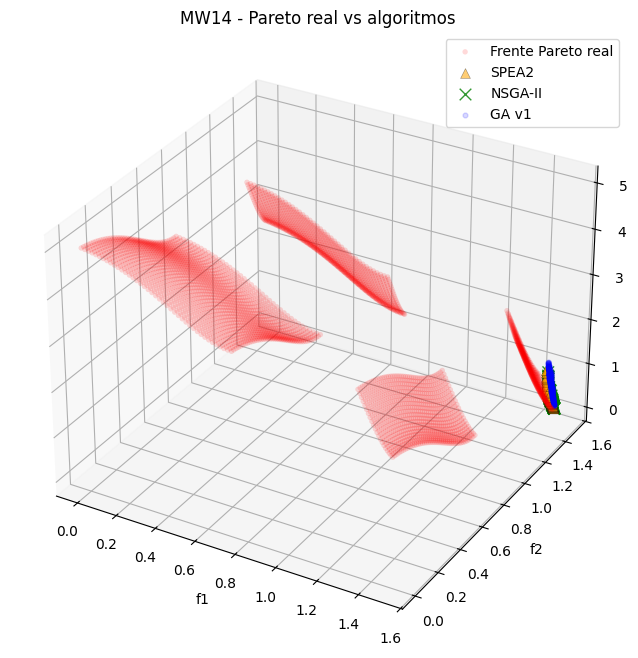

In [8]:
seed = 0
my = evolve_ag_1(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

plot_pareto_3d_mw14(problem, ns["F_nd"], sp["F_nd"], my["F_nd"],
                    title=f"MW14 - Pareto real vs algoritmos")


## Múltiples experimentos

In [9]:
ref_rows = []
rows = []

for seed in range(10):
    ag = evolve_ag_1(seed=seed)
    ns = run_nsga2(seed=seed)
    sp = run_spea2(seed=seed)

    all_nd = np.vstack([ag["F_nd"], ns["F_nd"], sp["F_nd"]])
    ref_point = ref_point_from_front(all_nd, margin=0.1)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df

,seed,HV_AG,SPR_AG,SPA_AG,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.016168,0.348912,0.005565,0.017446,0.309249,0.005384,0.018973,0.327205,0.006370
1,1,0.276732,0.162960,0.114083,0.052085,0.352884,0.006232,0.056541,0.362095,0.005576
2,2,0.145899,0.073480,0.020797,0.052656,0.406329,0.007578,0.058489,0.433835,0.007889
3,3,0.095980,0.023080,0.010318,0.044794,0.309402,0.006302,0.052716,0.300814,0.006347
4,4,0.010179,0.226260,0.002860,0.018926,0.367069,0.007021,0.018951,0.373154,0.006594
5,5,0.486406,0.356266,0.007387,0.058014,0.261301,0.005807,0.089694,0.423078,0.007033
6,6,0.094756,0.028946,0.054037,0.054860,0.385611,0.006115,0.058025,0.459627,0.007085
7,7,0.101024,0.034483,0.031608,0.053855,0.367147,0.006277,0.076880,0.530285,0.007819
8,8,0.271243,0.164177,0.015172,0.064887,0.441548,0.006833,0.069545,0.494372,0.006707
9,9,0.223636,0.154607,0.044559,0.059969,0.429226,0.007496,0.054148,0.326802,0.006508


### Estadísticas (media y desviación típica)

In [10]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.172203,0.030639,0.047749,0.006504,0.055396,0.006793
std,0.145399,0.033985,0.016455,0.000713,0.022409,0.000698


## Mejor experimento de AG

Best seed (AG) = 5


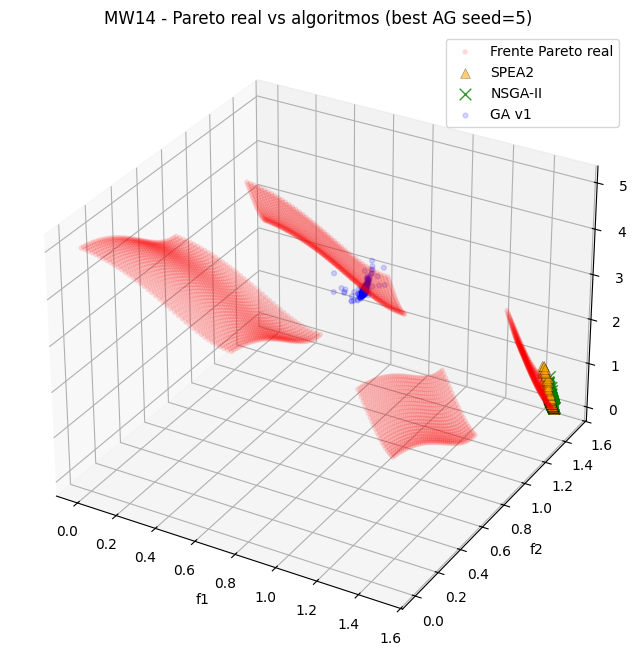

In [11]:
best_seed = int(df.loc[df["HV_AG"].idxmax(), "seed"])
print("Best seed (AG) =", best_seed)

ag = evolve_ag_1(seed=best_seed)
ns = run_nsga2(seed=best_seed)
sp = run_spea2(seed=best_seed)

plot_pareto_3d_mw14(
    problem,
    ns["F_nd"],
    sp["F_nd"],
    ag["F_nd"],
    title=f"MW14 - Pareto real vs algoritmos (best AG seed={best_seed})"
)


## GA v2: sustitución de operadores (SBX + mutación polinómica)

En esta sección se define una segunda variante del algoritmo genético adaptado (GA v2).
La estructura general del algoritmo se mantiene (manejo de restricciones mediante CV y penalización, selección ambiental por ordenación no dominada y crowding distance y selección parental por torneo).

La modificación principal respecto a GA v1 consiste en sustituir los operadores:

- Cruce aritmético -> Cruce SBX (Simulated Binary Crossover)
- Mutación gaussiana -> Mutación polinómica (Polynomial Mutation)

Estos son los más habituales en optimización multiobjetivo con variables reales y son los mismos que hemos utilizado en NSGA-II y SPEA2.

In [12]:
def sbx_crossover_vec(p1, p2, pcross=0.9, eta=15):
    if random.random() > pcross:
        return p1.copy(), p2.copy()

    n = len(p1)
    c1 = p1.copy()
    c2 = p2.copy()

    for i in range(n):
        if random.random() <= 0.5 and abs(p1[i] - p2[i]) > 1e-14:
            x1 = min(p1[i], p2[i])
            x2 = max(p1[i], p2[i])

            rand = random.random()

            beta = 1.0 + (2.0*(x1 - XL[i])/(x2 - x1))
            alpha = 2.0 - beta**(-(eta+1.0))
            if rand <= 1.0/alpha:
                betaq = (rand*alpha)**(1.0/(eta+1.0))
            else:
                betaq = (1.0/(2.0 - rand*alpha))**(1.0/(eta+1.0))
            child1 = 0.5*((x1+x2) - betaq*(x2-x1))

            beta = 1.0 + (2.0*(XU[i] - x2)/(x2 - x1))
            alpha = 2.0 - beta**(-(eta+1.0))
            if rand <= 1.0/alpha:
                betaq = (rand*alpha)**(1.0/(eta+1.0))
            else:
                betaq = (1.0/(2.0 - rand*alpha))**(1.0/(eta+1.0))
            child2 = 0.5*((x1+x2) + betaq*(x2-x1))

            if random.random() < 0.5:
                c1[i], c2[i] = child2, child1
            else:
                c1[i], c2[i] = child1, child2

    return np.clip(c1, XL, XU), np.clip(c2, XL, XU)


def polynomial_mutation_vec(x, pmut=None, eta=20):
    if pmut is None:
        pmut = 2.0 / N_VAR

    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            xl, xu = XL[i], XU[i]
            if xu - xl < 1e-14:
                continue

            delta1 = (y[i] - xl) / (xu - xl)
            delta2 = (xu - y[i]) / (xu - xl)
            rand = random.random()
            mut_pow = 1.0 / (eta + 1.0)

            if rand < 0.5:
                xy = 1.0 - delta1
                val = 2.0*rand + (1.0 - 2.0*rand)*(xy**(eta+1.0))
                deltaq = val**mut_pow - 1.0
            else:
                xy = 1.0 - delta2
                val = 2.0*(1.0-rand) + 2.0*(rand-0.5)*(xy**(eta+1.0))
                deltaq = 1.0 - val**mut_pow

            y[i] = y[i] + deltaq*(xu - xl)
            y[i] = min(max(y[i], xl), xu)

    return y

def evolve_ag_2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN,
                     pcross=0.9, eta_sbx=15, pmut=None, eta_mut=20):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F, CV = eval_pop(pop)
    F_sel = F + PENALTY * CV[:, None]

    pop, F, F_sel, CV, rank, crowd = environmental_selection(pop, F, F_sel, CV, pop_size)

    for _ in range(n_gen):
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd, CV)
            p2 = tournament_select(pop, rank, crowd, CV)

            c1, c2 = sbx_crossover_vec(p1, p2, pcross=pcross, eta=eta_sbx)
            c1 = polynomial_mutation_vec(c1, pmut=pmut, eta=eta_mut)
            c2 = polynomial_mutation_vec(c2, pmut=pmut, eta=eta_mut)

            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)
        Fc, CVc = eval_pop(children)
        Fc_sel = Fc + PENALTY * CVc[:, None]

        pop_all  = np.vstack([pop, children])
        F_all    = np.vstack([F, Fc])
        Fsel_all = np.vstack([F_sel, Fc_sel])
        CV_all   = np.hstack([CV, CVc])

        pop, F, F_sel, CV, rank, crowd = environmental_selection(pop_all, F_all, Fsel_all, CV_all, pop_size)

    feas = (CV <= FEAS_EPS)
    if np.any(feas):
        Ff = F[feas]
        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        F_nd = Ff[nd]
    else:
        idx = np.argsort(CV)[:min(len(CV), pop_size)]
        F_nd = F[idx]

    F_nd = np.unique(F_nd, axis=0)
    return {"pop": pop, "F": F, "CV": CV, "F_nd": F_nd}

## Experimento único

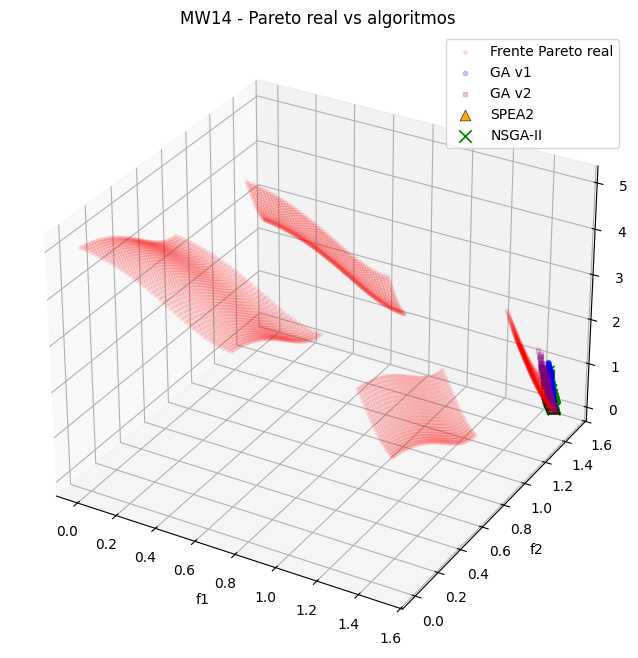

In [13]:
seed = 0
ag1 = evolve_ag_1(seed=seed)
ag2 = evolve_ag_2(seed=seed)
ns  = run_nsga2(seed=seed)
sp  = run_spea2(seed=seed)

plot_pareto_3d_mw14_4(
    problem,
    ns["F_nd"], sp["F_nd"],
    ag1["F_nd"], ag2["F_nd"],
    title=f"MW14 - Pareto real vs algoritmos",
    max_ga_points=800
)

## Múltiples experimentos

In [14]:
rows = []

for seed in range(10):
    ag1 = evolve_ag_1(seed=seed)
    ag2 = evolve_ag_2(seed=seed)
    ns  = run_nsga2(seed=seed)
    sp  = run_spea2(seed=seed)

    all_nd = np.vstack([ag1["F_nd"], ag2["F_nd"], ns["F_nd"], sp["F_nd"]])
    ref_point = ref_point_from_front(all_nd, margin=0.1)

    hv_ag1, spr_ag1, spa_ag1 = calculate_metrics(ag1["F_nd"], ref_point)
    hv_ag2, spr_ag2, spa_ag2 = calculate_metrics(ag2["F_nd"], ref_point)
    hv_n,   spr_n,   spa_n   = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,   spr_s,   spa_s   = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag1, "SPR_AG": spr_ag1, "SPA_AG": spa_ag1,
        "HV_AG2": hv_ag2, "SPR_AG2": spr_ag2, "SPA_AG2": spa_ag2,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df

,seed,HV_AG,SPR_AG,SPA_AG,HV_AG2,SPR_AG2,SPA_AG2,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.021663,0.348912,0.005565,0.032359,0.492158,0.009107,0.022254,0.309249,0.005384,0.024249,0.327205,0.006370
1,1,0.276732,0.162960,0.114083,0.087058,0.518168,0.011080,0.052085,0.352884,0.006232,0.056541,0.362095,0.005576
2,2,0.145909,0.073480,0.020797,0.074798,0.495308,0.009670,0.052681,0.406329,0.007578,0.058517,0.433835,0.007889
3,3,0.095990,0.023080,0.010318,0.075601,0.477321,0.008874,0.044826,0.309402,0.006302,0.052750,0.300814,0.006347
4,4,0.012378,0.226260,0.002860,0.029725,0.476416,0.009119,0.022177,0.367069,0.007021,0.022146,0.373154,0.006594
5,5,0.486419,0.356266,0.007387,0.096824,0.506868,0.011086,0.058026,0.261301,0.005807,0.089710,0.423078,0.007033
6,6,0.094766,0.028946,0.054037,0.069172,0.439760,0.007585,0.054896,0.385611,0.006115,0.058055,0.459627,0.007085
7,7,0.101024,0.034483,0.031608,0.070089,0.456024,0.009010,0.053855,0.367147,0.006277,0.076880,0.530285,0.007819
8,8,0.271258,0.164177,0.015172,0.071097,0.481476,0.008562,0.064912,0.441548,0.006833,0.069570,0.494372,0.006707
9,9,0.223636,0.154607,0.044559,0.080906,0.549440,0.009628,0.059969,0.429226,0.007496,0.054148,0.326802,0.006508


In [15]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
    "HV_AG2", "SPA_AG2",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_AG2,SPA_AG2,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.172977,0.030639,0.068763,0.009372,0.048568,0.006504,0.056257,0.006793
std,0.144483,0.033985,0.021627,0.001073,0.014858,0.000713,0.020909,0.000698


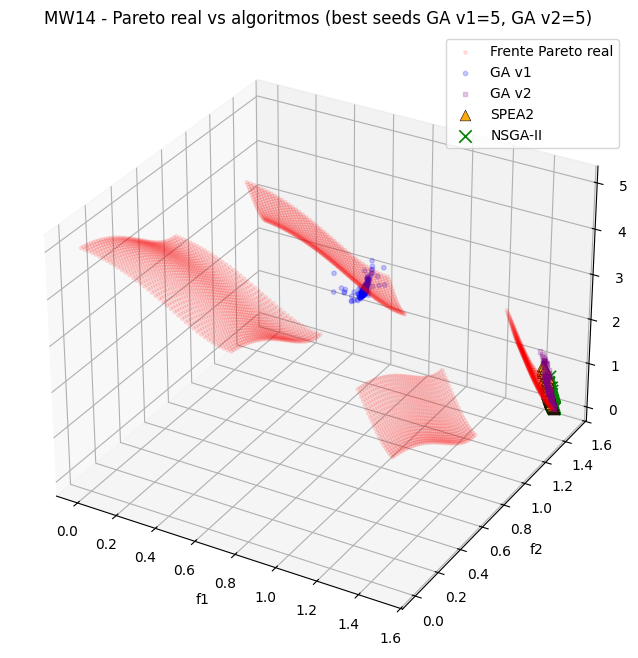

In [16]:
best_seed_ag1 = int(df.loc[df["HV_AG"].idxmax(), "seed"])
best_seed_ag2 = int(df.loc[df["HV_AG2"].idxmax(), "seed"])

ag1 = evolve_ag_1(seed=best_seed_ag1)
ag2 = evolve_ag_2(seed=best_seed_ag2)
ns  = run_nsga2(seed=best_seed_ag1)
sp  = run_spea2(seed=best_seed_ag1)

plot_pareto_3d_mw14_4(
    problem,
    ns["F_nd"], sp["F_nd"],
    ag1["F_nd"], ag2["F_nd"],
    title=f"MW14 - Pareto real vs algoritmos (best seeds GA v1={best_seed_ag1}, GA v2={best_seed_ag2})",
    max_ga_points=800
)

## Conclusiones

Los resultados muestran que ambas versiones del algoritmo genético generan soluciones factibles y alcanzan distintas regiones del frente de Pareto. En particular, GA v1 obtiene valores elevados de hipervolumen en algunas ejecuciones, aunque con una variabilidad muy alta entre seeds y una distribución poco uniforme de las soluciones. Por el contrario, GA v2 presenta valores de hipervolumen más moderados, pero con un comportamiento significativamente más estable, observable en una menor desviación típica y mejores valores de spacing.

Los algoritmos de referencia, NSGA-II y SPEA2, muestran un comportamiento más consistente, con frentes más regulares y valores de spacing bajos, aunque sin alcanzar los máximos valores puntuales de hipervolumen observados en GA v1.

En conjunto, los resultados indican que, en el problema MW14, la estabilidad y la uniformidad en la distribución de las soluciones resultan más importantes que la obtención de valores elevados de hipervolumen en ejecuciones únicas, lo que destaca la dificultad del problema bajo un presupuesto de evaluaciones limitado y la naturaleza separable de su frente de Pareto.